# Entity Linking
The tutorial documents how one may use the **Entity Linking** tool in spaCy to resolve the ambiguous mentioning via using unique identifers in a knowledge base (KB). The following tools may be needed. 

In [ ]:
# !python3 -m spacy download zh_core_web_md

In [2]:
from IPython.display import Image as IPythonImage
import spacy
import chinese_converter


nlp = spacy.load("zh_core_web_md")
text = chinese_converter.to_simplified("呈復臺籍國大代表黃國書陰謀叛國一案尚無事實證明在此善後時期擬不予深究")
doc = nlp(text)
for ent in doc.ents:
    print(f"Named Entity '{ent.text}' with label '{ent.label_}'")

Named Entity '台籍' with label 'GPE'
Named Entity '国大' with label 'ORG'
Named Entity '黄国书' with label 'PERSON'


In [3]:
import spacy
import chinese_converter
from spacy import displacy


nlp = spacy.load("zh_core_web_md")
text = chinese_converter.to_simplified("1947年黃國書當選立法委員")
doc = nlp(text)
displacy.render(doc, style='ent')
displacy.render(doc, style="dep")

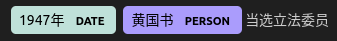

In [4]:
IPythonImage(filename="imgs/ent.png", width=500)

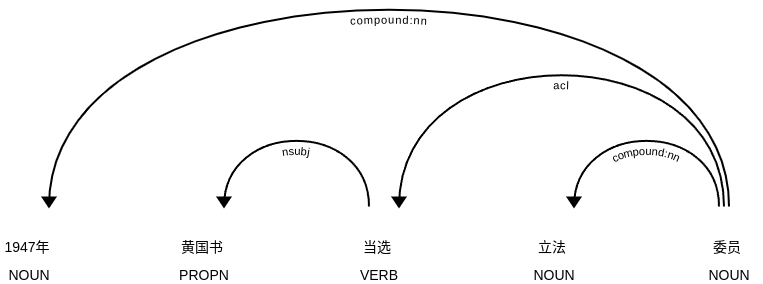

In [5]:
IPythonImage(filename="imgs/dep.png", width=500)

# Creating the Knowledge Base 

The first step to perform Entity Linking, is to set up a Knowledge Base (KB) that contains the unique identifiers of the entities we are interested in. This tutorial will create a 2-entry KB. The KB is established based on the information in [wikidata](https://www.wikidata.org/wiki/) and saves to a csv file. 

In [6]:
import csv
from pathlib import Path


def load_entities(file):
    entities_loc = Path.cwd().parent / "assets" / file

    names = dict()
    names_aliases = dict()
    descriptions = dict()
    with entities_loc.open("r", encoding="utf8") as csvfile:
        csvreader = csv.reader(csvfile, delimiter=",")
        for row in csvreader:
            qid = row[0]
            name = row[1]
            desc = row[2]
            name_alias = row[4]
            
            names[qid] = name
            descriptions[qid] = desc
            names_aliases[qid] = name_alias
    return names, descriptions, names_aliases

In [7]:
data_folder = "assets"
entitye_file = "entities.csv"
input_file = "input_text60.txt"
output_dir = Path.cwd().parent / "my_output"


entities_loc = Path.cwd().parent / data_folder / entitye_file  # distributed alongside this notebook
name_dict, desc_dict, alias_dict = load_entities(entitye_file)
for QID in name_dict.keys():
    print(f"{QID}, name={name_dict[QID]}, desc={desc_dict[QID]}, alias={alias_dict[QID]}")

Q111361019, name=黃國書, desc=中華民國軍政人物、中華民國陸軍中將、政治人物，立法院长, alias=老黄国书
Q19058548, name=黃國書, desc=臺灣政治人物，1964年生, alias=小黄国书


There are two entries, recording 2 different people called 黃國書. Both are Taiwanese politicians. The former climbed the ladder to become the speaker of the Legislative Yuan. The latter was born later, and is also a legislator. The difference is the he has never become the speaker of the Yuan. I'll use this information to create the KB. The entity vector is a numerical vector with a fixed dimension, here defining to be 300 elements.

To add each record to the knowledge base, the description from the wikidata are converted to the built-in word vectors of the `nlp` model. The `vector` attribute of a document is the average of its token vectors. We also need to provide a frequency, which is a raw count of how many times a certain entity appears in an annotated corpus. The corpus plays no role in this tutorial, so it has never been used and the frequency is set to an arbitrary value.

* To specify aliases (or synonyms), I use the adjective, senior and junior to denote the two people, resolving to their corresponding QID, because no ambiguity in this case (<span style="color:red">IMPORTANT</span>). It is uncertain that what role the second alias plays. But they are added anyway. 

In [26]:
from spacy.kb import InMemoryLookupKB


kb = InMemoryLookupKB(vocab=nlp.vocab, entity_vector_length=300)
for qid, desc in desc_dict.items():
    text = chinese_converter.to_simplified(desc)
    desc_doc = nlp(text)
    desc_enc = desc_doc.vector
    # 342 is an arbitrary value here
    kb.add_entity(entity=qid, entity_vector=desc_enc, freq=342)   

for qid, name in alias_dict.items():
    kb.add_alias(alias=name, entities=[qid], probabilities=[1])    


qids = name_dict.keys()  
probs = [0.5 for qid in qids]
kb.add_alias(alias="黄国书", entities=qids, probabilities=probs)  

15382059974437885320

* The following checks check the entities and aliases that are contained in it, and 
* then print the candidates that are generated for the distinct name of 老黄国书, as well as for the ambiguious mentioning, "黄国书" or for another random mentioning that is also a politician, with a different, distinguishable, but similar name, "王成章".

In [27]:
print(f"Entities in the KB: {kb.get_entity_strings()}")
print(f"Aliases in the KB: {kb.get_alias_strings()}")
print(f"Candidates for '老黄国书': {[c.entity_ for c in kb.get_alias_candidates('老黄国书')]}")
print(f"Candidates for '黄国书': {[c.entity_ for c in kb.get_alias_candidates('黄国书')]}")
print(f"Candidates for '王成章': {[c.entity_ for c in kb.get_alias_candidates('王成章')]}")

Entities in the KB: ['Q111361019', 'Q19058548']
Aliases in the KB: ['黄国书', '老黄国书', '小黄国书']
Candidates for '老黄国书': ['Q111361019']
Candidates for '黄国书': ['Q111361019', 'Q19058548']
Candidates for '王成章': []


* When querying the KB with the alias "黄国书", it gives 2 candidates, but if querying it with an unknown term, it gives an empty list.
* Next, we can save the knowledge base by calling the function `to_disk` with an output location.
* We can store the `nlp` object to file by calling `to_disk` as well.

In [28]:
# change the directory and file names to whatever you like
import os
if not os.path.exists(output_dir):
    os.mkdir(output_dir) 
kb.to_disk(output_dir / "my_kb")
nlp.to_disk(output_dir / "my_nlp")

# Creating a training dataset

In [29]:
import spacy
from spacy import displacy


input_data = Path.cwd().parent / data_folder / input_file

X_train = []
with open(input_data, 'r', encoding='utf-8') as dataset:
    for i, line in enumerate(dataset):
        line = line.strip('\n')
        X_train.append(line)
        if i < 2:
            print(i, ":", line)

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

0 : 因此無論在立法院擔任副院長及院長期間，外交工作均是黃國書先生的重要工作，在副院長期間的外交，可分為反共外交及接待外賓兩大主軸，以下詳論之
1 : 以外交見長的黃國書先生在此「反共外交」中也扮演重要角色。
民进党 0 3 ORG
黄国书 5 8 PERSON
今天 8 10 DATE
曾迫于 18 21 GPE


In [30]:
nlp = spacy.load("zh_core_web_md")

for i, line in enumerate(X_train):
    text = chinese_converter.to_simplified(line)
    doc = nlp(text)
    if i < 3:
        displacy.render(doc, style='ent')

In [31]:
nlp = spacy.load("zh_core_web_md")
X_train, starts, ends, labels, texts = [], [], [], [], []

with open(input_data, 'r', encoding='utf-8') as dataset:
    for i, line in enumerate(dataset):
        line = line.strip('\n')
        text = chinese_converter.to_simplified(line)
        X_train.append(text)

        doc = nlp(text)
        for ent in doc.ents:
           if ent.text == '黄国书':
               texts.append(ent.text)
               starts.append(ent.start_char)
               ends.append(ent.end_char)
               labels.append(ent.label_)

len(texts), len(starts), len(ends), len(labels)

(60, 60, 60, 60)

In [32]:
spans_keys = ['start', 'end', 'text', 'rank', 'label']
rank = 0
span_list = []


for i in range(len(X_train)):
    start = starts[i]
    end = ends[i]
    text = texts[i]
    label = labels[i]
    spans_values = [start, end, text, rank, label]
    output = {}

    for j in range(len(spans_values)):
        output.update({spans_keys[j]: spans_values[j]})
        
    span_list.append(output)

span_list[:3]

[{'start': 25, 'end': 28, 'text': '黄国书', 'rank': 0, 'label': 'PERSON'},
 {'start': 6, 'end': 9, 'text': '黄国书', 'rank': 0, 'label': 'PERSON'},
 {'start': 10, 'end': 13, 'text': '黄国书', 'rank': 0, 'label': 'PERSON'}]

In [33]:
keys = ['text', 'spans', 'accept', 'answer']
jsonl_output = []

for i, line in enumerate(X_train):
    if i <30:
        qid = 'Q111361019'
    else :
        qid = 'Q19058548'

    text_ = chinese_converter.to_simplified(line)
    values = [text_, span_list[i], qid, "accept"]

    output = {}
    for j in range(len(keys)):
        output.update({keys[j]: values[j]})
 
    jsonl_output.append(output)

In [34]:
import json

# Write each list item as a separate JSON object in the file
with open("../assets/annotated_text60.jsonl", "w") as jsonl_file:
    for item in jsonl_output:
        json.dump(item, jsonl_file, ensure_ascii=False)
        jsonl_file.write("\n")  # Add a newline after each object

 * The json file stores the full text of the sentence, together with a lot of annotations. 
 * The important bit is the element with the key `accept`. This is the `y` variable, or another commonly used name, the `label` . 
 * For this specific sentence and this specific mentioning, the option with key `Q111361019` was manually selected. 

# Training the Entity Linker

To feed training data into our Entity Linker, we format our data as a structured tuple. The first part is the raw text, and the second part is a dictionary of annotations. This dictionary defines the named entities we want to link ("entities"), as well as the actual gold-standard links ("links").

In [35]:
dataset = []
json_loc = Path.cwd().parent / data_folder / "annotated_text60.jsonl"

with json_loc.open("r", encoding="utf8") as jsonfile:
    for line in jsonfile:
        example = json.loads(line)
        text = example["text"]
        if example["answer"] == "accept":
            QID = example["accept"]
            
            offset = (example["spans"]["start"], example["spans"]["end"])
            entity_label = example["spans"]["label"]
            entities = [(offset[0], offset[1], entity_label)]
            links_dict = {QID: 1.0}   # The QID is always paired with "1" (ie True), meaning the QID is a correct one (ie manually selected).
        dataset.append((text, {"links": {offset: links_dict}, "entities": entities}))

To check whether the conversion looks OK, we can just print the first sample in our dataset. 

In [36]:
# dataset is a 2-element tuple, with its second element a dictionary, which carries  more elements.
dataset[0]

('因此无论在立法院担任副院长及院长期间，外交工作均是黄国书先生的重要工作，在副院长期间的外交，可分为反共外交及接待外宾两大主轴，以下详论之',
 {'links': {(25, 28): {'Q111361019': 1.0}}, 'entities': [(25, 28, 'PERSON')]})

In [37]:
from collections import Counter

y = []
for text, annot in dataset:
    for span, links_dict in annot["links"].items():
        for link, value in links_dict.items():
            if value:
                y.append(link)

print(Counter(y))

Counter({'Q111361019': 30, 'Q19058548': 30})


We got exactly 10 annotated sentences for each of our Emersons. Of these, we'll now set aside 6 cases in a separate test set.

In [38]:
train_dataset = []
test_dataset = []
for k, QID in enumerate(qids):
    indices = [i for i, j in enumerate(y) if j == QID]
    # From Counter, we know that Counter({'Q111361019': 30, 'Q19058548': 30})
    # Thus, at each iteration, the indices variable becomes a 30-element index, 
    # all pointing to a unique candidate.
    #
    # Then, the following manually assigns first 26 sentences to the train_dataset, 
    # and the last 2 were assigned to the test_dataset.
    train_dataset.extend(dataset[index] for index in indices[0:26])  
    test_dataset.extend(dataset[index] for index in indices[26:60])  


In [39]:
import random

random.shuffle(train_dataset)
random.shuffle(test_dataset)
len(train_dataset), len(test_dataset)

(52, 8)

## Example Class

With our datasets now properly set up, we'll now create an `Example` object to feed into the training process. This object is new in spaCy v3. Essentially, it contains a document with predictions (`predicted`) and one with gold-standard annotations (`reference`). 

For entity linking, the algorithm needs access to gold-standard sentences, because the algorithms use the context from the sentence to perform the disambiguation. You can either provide gold-standard `sent_starts` annotations, or run a component such as the `parser` or `sentencizer` on your reference documents.

In [40]:
from spacy.training import Example

TRAIN_EXAMPLES = []
if "sentencizer" not in nlp.pipe_names:
    nlp.add_pipe("sentencizer")
sentencizer = nlp.get_pipe("sentencizer")

for text, annotation in train_dataset:
    example = Example.from_dict(nlp.make_doc(text), annotation)
    example.reference = sentencizer(example.reference)
    TRAIN_EXAMPLES.append(example) 

Then, we'll create a new Entity Linking component and add it to the pipeline. 

We also need to make sure the `entity_linker` component is properly initialized. To do this, we need a `get_examples` function that returns some example training data, as well as a `kb_loader` argument. This is a `Callable` function that creates the `KnowledgeBase`, given a certain `Vocab` instance. Here, we will load our KB from disk, using the built-in [`spacy.KBFromFile.v1`](https://spacy.io/api/architectures#KBFromFile) function, which is defined in `spacy.ml.models`. 

In [41]:
from spacy.ml.models import load_kb

entity_linker = nlp.add_pipe("entity_linker", config={"incl_prior": False}, last=True)
entity_linker.initialize(get_examples=lambda: TRAIN_EXAMPLES, kb_loader=load_kb(output_dir / "my_kb"))

Next, we will run the actual training loop for the new component, taking care to only train the entity linker and not the other components. 

In [54]:
from spacy.util import minibatch, compounding

with nlp.select_pipes(enable=["entity_linker"]):   # train only the entity_linker
    optimizer = nlp.resume_training()
    
    for itn in range(100):   # 500 iterations takes about a minute to train
        random.shuffle(TRAIN_EXAMPLES)
        batches = minibatch(TRAIN_EXAMPLES, size=compounding(4.0, 32.0, 1.001))  # increasing batch sizes
        losses = {}
        for batch in batches:
            nlp.update(
                batch,   
                drop=0.2,      # prevent overfitting
                losses=losses,
                sgd=optimizer,
            )
        if itn % 50 == 0:
            print(itn, "Losses", losses)   # print the training loss

print(itn, "Losses", losses)


0 Losses {'entity_linker': 0.3940976560115814}
50 Losses {'entity_linker': 0.2215153376261393}
99 Losses {'entity_linker': 0.3127005994319916}


# Testing the Entity Linker

Let's first apply it on our original sentence. For each entity, we print the text and label as before, but also the disambiguated QID as predicted by our entity linker.

In [52]:
text = chinese_converter.to_simplified("黃國書也認為，基於兩個理由，臺灣的民主越來越進步")
doc = nlp(text)
for ent in doc.ents:
    # ent.kb_id_
    print(ent.text, ent.label_, ent.kb_id_)

黄国书 PERSON Q111361019
两 CARDINAL NIL
台湾 GPE NIL


We see that 黄国书 gets disambiguated to `Q111361019`, which is a correct ID. This may turn out incorrect, when the size of the dataset is limited. This sentence is particular difficult to tell apart because both candidates are legislators and this syntax of this sentence is commonly used both now and then. 

Let's see what the model predicts for the 6 sentences in our test dataset, that were never seen during training.

In [ ]:
true_y, predicted_y = [], []
accuracy_hist_test = [0] * len(test_dataset)

for i, (text, true_annot) in enumerate(test_dataset):
    doc = nlp(text) 
    for ent in doc.ents:
        if ent.text == "黄国书":
            py = ent.kb_id_
            predicted_y.append(ent.kb_id_)

    for span, links_dict in true_annot["links"].items():
       for link, value in links_dict.items():
           ty = link
           true_y.append(link)

    is_correct = float(py==ty)
    accuracy_hist_test[i] = is_correct

sum(accuracy_hist_test) / len(test_dataset)
# 0.875